![](https://brandingmonitor.pl/wp-content/uploads/2019/01/new-rebranding-sgh-nowe-logo.png)

Szkoła Główna Handlowa w Warszawie

Optymalizacja rozmieszczenia urządzeń na hali produkcyjnej firmy GWINTEX S.A

234060-0723 Zaawansowane modelowanie symulacyjne

- Uladzislau Darhevich 108519

# Podsumowanie

Na wybór rozmieszczenia urządzeń na hali produkcyjnej najbardziej wpływa dodatkowe koszty instalacji układu gniazdowego.  Przy różnice w kosztach do 1800 zł optymalnym będzie wybór układu gniazdowego, liczba zestawów narzędzi - 2. W innym wypadku optymalnym będzie wybór układu liniowego, liczba zestawów narzędzi - 3.

# Opis organizacji

Firma GWINTEX S.A. jest międzynarodowym potentatem w dziedzinie produkcji korkociągów. Korkociągi są wytwarzane na bardzo nowoczesnych maszynach metalurgicznych. W związku ze znacznym wzrostem zamówień firma planuje uruchomienie nowej hali produkcyjnej

# Opis problemu

Zarząd firmy GWINTEX zastanawia się **jakie powinno być rozmieszczenie urządzeń na hali produkcyjnej** oraz **ile pakietów narzędziowych do obsługi maszyn należy zakupić** Celem jest minimalizacja kosztów

# Wyniki analizy


In [236]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [233]:
# liczba maszyn
n = 6 

# średni czas pracy bez usterki
avg_working_time = 75 # minut

# średni czas naprawy
avg_repair_time = 15 # minut

# liczba zestawów narzędzi
m = 6

# horyzont analizy
horizon = 30 # dni

# liczba uruchomień symulacji
iterations = 10   

***Model***

Wektory, które mają za zadanie kontrolować stan symulacji:

- momenty wystąpienia kolejnych zdarzeń
- status narzędzi i maszyn 
    - `W` - pracuje 
    - `Q` - czeka na narzedzia 
    - `R` - jest naprawiona
- czas ich bezczynności
- events --> wektor zdarzeń, które zmieniają stan symulacji (np. zepsucie się maszyny, czas naprawy, itp.)

In [204]:
def model(horizon, avg_working_time, avg_repair_time, n, m, setup):
    # setup - układ liniowy "L" lub gniazdowy "G"
    
    # horyzont działania w minutach
    horizon = horizon * 24 * 60 
    
    # wektor zdarzeń, który zmienia stan symulacji
    events = list(np.random.exponential(avg_working_time, n))
    
    # status - określa aktualny stan maszyny 
    status = ["W"] * n

    # t_start - określa początek bezczynności maszyny
    t_start = [0] * n

    # t_cum - skumulowany czas bezczynności maszyny
    t_cum = [0] * n

    # tools_loc lokalizacja narzedzi - albo numer maszyny albo -1 czyli warsztat
    tools_loc = [-1] * m

    # tools_occupied czas zajecia zestawu przez naprawianą maszynę
    tools_occupied = [0] * m
    
    # zegar symulacji - najblizsze zadanie, które ma być wykonane
    t = min(events)
     
    # rozpoczynamy symulacje "skacząc" po kolejnych zdarzeniach  
    while t <= horizon:
        
        # jeżeli zestawy nie są aktualnie zajęte to przenosimy je z powrotem do warsztatu
        for i in range(m):
            if tools_occupied[i] <= t:
                tools_loc[i] = -1

        # wybieramy maszynę, której dotyczy zdarzenie
        machines = []
        for i in range(len(events)):
            if events[i] == t:
                machines.append(i)
        machine = machines[random.randint(0, len(machines)-1)]
        
        """
        Gdy maszyna, której dotyczy zdarzenie ma status "W":
            - to najpierw zaktualizuj wektor t_start dla tej maszyny jako początek jej bezczynności = t.
            - następnie sprawdź czy dostępny jest jakiś zestaw naprawczy. Jezeli nie:
                - to ustaw status maszyny na "Q" 
                - zaktualizuj wektor events podajac mu najkrótszy czas oczekiwania na wolny zestaw.
              Jeżeli tak:
                - ustaw status maszyny na "R"
                - wyznacz czas  potrzebny na naprawę maszyny w zależności od ukladu taśmociągu 
                (czas transportu + czas naprawy)
                - ustaw koniec naprawy jako zdarzenie dla danej maszyny
                - zaktualizuj wektor tools_loc dla odpowiedniego zestawu podając numer maszyny, którą on obsługuje
                - zaktualizuj wektor tools_occupied czasem jaki mu to zajmie (2* transport + naprawa)
        """
        if status[machine] == "W":
            t_start[machine] = t
            tools = - 1
            for i in range(m):
                if tools_loc[i] == -1:
                    tools = i
                    break
            if tools == -1 :
                status[machine] = "Q"
                events[machine] = min(tools_occupied)
            else:
                status[machine] = "R"
                if setup == "L":
                    transport_time = 2 * (1 + machine)
                elif setup == "G":
                    transport_time =  3
                else:
                    print("Niepoprawny układ! Należy wybrać układ 'L' lub 'G'!")
                    break
                repair_time = np.random.gamma(3, avg_repair_time/3)
                events[machine] += repair_time + transport_time
                tools_loc[tools] = machine
                tools_occupied[tools] = t + repair_time + 2 * transport_time
                
                """
                Gdy maszyna ma status "Q":
                    - wybierz dostępny zestaw naprawczy
                    - ustal status maszyny na "R"
                    - zaktualizuj wektor tools_loc lokalizacją narzedzi i tools_occupied 
                    czasem jaki zajmie ich transport (w dwie strony) i naprawa maszyny
                    -zaktualizuj wektor zdarzeń czasem potrzebnym na naprawę maszyny i transport narzedzi
                """
                
        elif status[machine] == "Q":
            tools = - 1
            for i in range(m):
                if tools_loc[i] == -1:
                    tools = i
                    break
            if tools == -1 :
                status[machine] = "Q"
                events[machine] = min(tools_occupied)
            else:
                status[machine] = "R"
                if setup == "L":
                    transport_time = 2 * (1 + machine)
                elif setup == "G":
                    transport_time =  3
                else:
                    print("zly uklad - moze byc L lub G!")
                    break
                repair_time = np.random.gamma(3, avg_repair_time/3)
                events[machine] += repair_time + transport_time
                tools_loc[tools] = machine
                tools_occupied[tools] = t + repair_time + 2 * transport_time 
            """
            Gdy maszyna ma status "R":
                - ustal jej status na "W"
                - wyznacz czas kolejnej awarii i zaktualizuj wektor events
                - wylicz czas bezczynnosci i uzupelnij o niego liste t_cum
            """
            
        else:
            status[machine] = "W"
            events[machine] += np.random.exponential(avg_working_time)
            t_cum[machine] += t - t_start[machine]
        
        # ustalamy nowe t
        t = min(events)
        
    # wynik - liste skumulowanych bezczynnosci dla kazdej z maszyn
    return (t_cum)

def run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m, setup):
    avg_t_cum = []
    for i in range (iterations):
        avg_t_cum.append(model(horizon, avg_working_time, avg_repair_time, n, m, setup))
    return list(map(np.mean, np.transpose(avg_t_cum)))

### Jak zmienia się optymalna liczba zestawów narzędziowych w zależności od kosztów przestoju i kosztów zestawu narzędzi w przypadku a) układu liniowego b) układu gniazdowego?

Do określenia optymalnej liczby zestawów narzędzi w zależności od kosztów przestoju i kosztów zestawu narzędzi, prowadzono symulację skumulowanego czasu bezczynności.
Wyniki symulacji zebrane w zbiorze `results`. Łączne koszty obejmują koszty przestojów, koszty i liczbę zestawów narzędzi oraz dodatkowe koszty instalacji w ustawieniu gniazdowym ("G"). Koszt przestoju maszyny oraz koszt zestawu narzędzi są czynnikami zmiennymi, dodatkowy koszt instalacji - czynnik stały. Za pomocą metod`groupby()` oraz `idxmin()` zbiór `results` z biblioteki **Pandas** został przetworzony w zbiór `pivot_df`, który zawiera wierszy z najmniejszymi wartościami łącznych kosztów dla zgrupowanych czynników.  


In [205]:
downtime_cost = [1, 1.5, 2.0] #Koszt przestoju maszyny (koszt jednostkowy np. za minutę przestoju)
kit_cost = [1000, 2000, 3000] #Koszt zestawu narzędzi
additional_socket_cost = 20000 #Dodatkowy koszt instalacji w ustawieniu gniazdowym ("G") w porównaniu do instalacji liniowej ("L")
results = pd.DataFrame(columns=['Type', 'm', 'downtime_cost', 'kit_cost', 'additional_socket_cost', 'avg_downtime'])

In [206]:
%%time
for setup in ["L", "G"]:
    for c in downtime_cost:
        for kc in kit_cost:
            for m in range(1, 6):
                results = results.append({'Type' : setup, 
                                          'm' : m,
                                          'downtime_cost' : c,
                                          'kit_cost' : kc,
                                          'avg_downtime' : np.mean(run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m, setup))}, 
                                          ignore_index=True)

Wall time: 1min 17s


In [207]:
results['additional_socket_cost'] = np.where(results['Type'] == "G", additional_socket_cost, 0)
results['Total_costs'] = results['avg_downtime']*results['downtime_cost'] + results['m']*results['kit_cost'] + results['additional_socket_cost']
results['Total_costs'] = results['Total_costs'].astype('float')
pivot_df = results.loc[results.groupby(["Type", "downtime_cost", "kit_cost"])['Total_costs'].idxmin()]

In [208]:
pivot_df

,Type,m,downtime_cost,kit_cost,additional_socket_cost,avg_downtime,Total_costs
47,G,3,1,1000,20000,8496.253550,31496.253550
51,G,2,1,2000,20000,9759.060139,33759.060139
56,G,2,1,3000,20000,9876.944638,35876.944638
62,G,3,1.5,1000,20000,8512.171784,35768.257676
66,G,2,1.5,2000,20000,9769.134830,38653.702245
71,G,2,1.5,3000,20000,9769.237298,40653.855947
77,G,3,2.0,1000,20000,8603.381456,40206.762911
82,G,3,2.0,2000,20000,8517.975383,43035.950767
86,G,2,2.0,3000,20000,9829.845145,45659.690289
2,L,3,1,1000,0,10360.539562,13360.539562


Z podanej wyżej tabeli widać jak zmienia się optymalna liczba zestawów narzędziowych w zależności od kosztów przestoju i kosztów zestawu narzędzi. Dla instalacji liniowej ("L") to 2, 3 lub 4 ***(najczęściej - 3)***, w ustawieniu gniazdowym ("G") - 2 lub 3 ***(najczęściej - 2)***

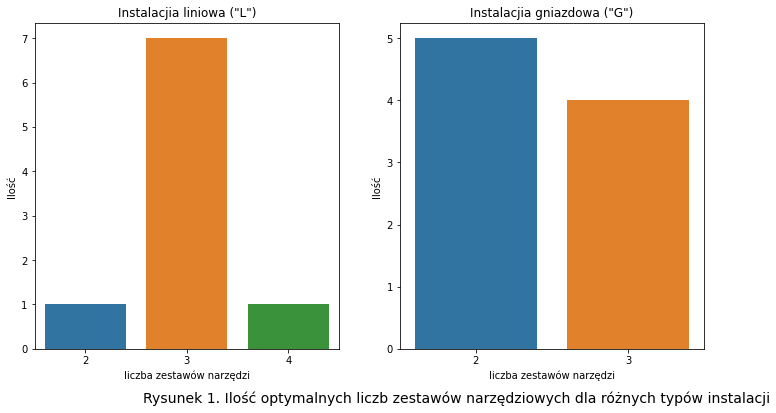

In [209]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
g1 = sns.barplot(x=pivot_df[pivot_df['Type'] == "L"]['m'].value_counts().index,
                 y=pivot_df[pivot_df['Type'] == "L"]['m'].value_counts().values,
                 ax=axs[0])
g1.set_title('Instalacjia liniowa ("L")')
g1.set(xlabel="liczba zestawów narzędzi", ylabel = "Ilość")

g2 = sns.barplot(x=pivot_df[pivot_df['Type'] == "G"]['m'].value_counts().index,
                 y=pivot_df[pivot_df['Type'] == "G"]['m'].value_counts().values,
                 ax=axs[1])
g2.set_title('Instalacjia gniazdowa ("G")')
g2.set(xlabel="liczba zestawów narzędzi", ylabel = "Ilość")

fig.text(0.25, 0, "Rysunek 1. Ilość optymalnych liczb zestawów narzędziowych dla różnych typów instalacji",
            fontsize=14); 

### Który układ produkcyjny jest lepszy w zależności od kosztów przestoju i różnicy między kosztem instalacji "G" i "L"?

Dalej badano, który układ produkcyjny jest lepszy w zależności od kosztów przestoju i różnicy między kosztem instalacji "G" i "L" (m=6). Zmieniają się wartości kosztu przestoju maszyny oraz dodatkowy koszt instalacji w ustawieniu gniazdowym ("G") w porównaniu do instalacji liniowej ("L"). Wyniki symulacji zebrane w zbiorze `results`. Łączne koszty obejmują koszty przestojów, koszty i liczbę zestawów narzędzi oraz dodatkowe koszty instalacji w ustawieniu gniazdowym ("G").

In [210]:
downtime_cost = [1, 1.5, 2.0] #Koszt przestoju maszyny (koszt jednostkowy np. za minutę przestoju)
kit_cost = 1000 #Koszt zestawu narzędzi
additional_socket_cost = [200, 20000, 30000] #Dodatkowy koszt instalacji w ustawieniu gniazdowym ("G") w porównaniu do instalacji liniowej ("L")
results = pd.DataFrame(columns=['Type', 'downtime_cost', 'additional_socket_cost', 'avg_downtime'])

In [211]:
%%time
for setup in ["L", "G"]:
    for c in downtime_cost:
        if setup == "L":
                results = results.append({'Type' : setup, 
                                          'downtime_cost' : c,
                                          'additional_socket_cost' : 0,
                                          'avg_downtime' : np.mean(run_model(iterations, horizon, avg_working_time, avg_repair_time, n, 6, setup))}, 
                                          ignore_index=True)
        else:
            for ac in additional_socket_cost:
                results = results.append({'Type' : setup, 
                                          'downtime_cost' : c,
                                          'additional_socket_cost' : ac,
                                          'avg_downtime' : np.mean(run_model(iterations, horizon, avg_working_time, avg_repair_time, n, 6, setup))}, 
                                          ignore_index=True)

Wall time: 10.5 s


In [212]:
results['Total_costs'] = results['avg_downtime']*results['downtime_cost'] + 6*kit_cost + results['additional_socket_cost']
results

,Type,downtime_cost,additional_socket_cost,avg_downtime,Total_costs
0,L,1,0,9761.603073,15761.603073
1,L,1.5,0,9853.027435,20779.541152
2,L,2.0,0,9768.548843,25537.097686
3,G,1,200,8393.339865,14593.339865
4,G,1,20000,8365.885550,34365.88555
5,G,1,30000,8307.078171,44307.078171
6,G,1.5,200,8400.445601,18800.668402
7,G,1.5,20000,8313.261282,38469.891922
8,G,1.5,30000,8318.503466,48477.755198
9,G,2.0,200,8387.219948,22974.439896


Z podanej wyżej tabeli widać, że różnica między dodatkowym kosztem instalacji w ustawieniu gniazdowym ("G") bardzo mocno wpływa na łączne koszty. Wybór instalacji liniowej ("L") jest wyborem optymalnym.  Jednak jeżeli nie ma różnicy pomiędzy kosztami instalacji lub ona jest mała, to lepiej wybrać ustawienie gniazdowe ("G")

### Jak zmienia się rozwiązanie optymalne o możliwych wartościach "G1, G2,...,G6" lub "L1, L2, ..., L6" (pierwszy znak - układ produkcyjny, drugi znak - liczba zestawów narzędzi max.6) w zależności od wszystkich 3 źródeł kosztów podanych powyżej. 

W tym przypadku zmieniają się liczba zestawów narzędzi, wartości kosztu przestoju maszyny, koszt zestawu narzędzi oraz dodatkowy koszt instalacji w ustawieniu gniazdowym ("G") w porównaniu do instalacji liniowej ("L"). Wyniki symulacji zebrane w zbiorze results. Łączne koszty obejmują koszty przestojów, koszty i liczbę zestawów narzędzi oraz dodatkowe koszty instalacji w ustawieniu gniazdowym ("G").

In [213]:
downtime_cost = [1, 1.5, 2.0] #Koszt przestoju maszyny (koszt jednostkowy np. za minutę przestoju)
kit_cost = [1000, 2000, 3000] #Koszt zestawu narzędzi
additional_socket_cost = [1800, 20000, 30000] #Dodatkowy koszt instalacji w ustawieniu gniazdowym ("G") w porównaniu do instalacji liniowej ("L")
results = pd.DataFrame(columns=['Type', 'm', 'downtime_cost', 'kit_cost', 'additional_socket_cost', 'avg_downtime'])

In [214]:
%%time
for setup in ["L", "G"]:
    for c in downtime_cost:
        for kc in kit_cost:
            if setup == "L":
                for m in range(1, 7):
                    results = results.append({'Type' : setup, 
                                          'm' : m,
                                          'downtime_cost' : c,
                                          'kit_cost' : kc,
                                          'additional_socket_cost' : 0,
                                          'avg_downtime' : np.mean(run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m, setup))}, 
                                          ignore_index=True)
            else:
                for ac in additional_socket_cost:
                    for m in range(1, 7):
                        results = results.append({'Type' : setup, 
                                                  'm' : m, 
                                                  'downtime_cost' : c,
                                                  'kit_cost' : kc,
                                                  'additional_socket_cost' : ac, 
                                                  'avg_downtime' : np.mean(run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m, setup))}, 
                                                ignore_index=True)

Wall time: 3min 4s


In [215]:
results['Total_costs'] = results['avg_downtime']*results['downtime_cost'] + results['m']*results['kit_cost'] + results['additional_socket_cost']
results['Total_costs'] = results['Total_costs'].astype('float')
pivot_df = results.loc[results.groupby(["Type", "downtime_cost", "kit_cost", "additional_socket_cost"])['Total_costs'].idxmin()]
pivot_df.sort_values(by='Total_costs').head(10)

,Type,m,downtime_cost,kit_cost,additional_socket_cost,avg_downtime,Total_costs
2,L,3,1,1000,0,10330.799797,13330.799797
56,G,3,1,1000,1800,8611.662654,13411.662654
73,G,2,1,2000,1800,9893.297637,15693.297637
8,L,3,1,2000,0,10204.495964,16204.495964
91,G,2,1,3000,1800,9665.242489,17465.242489
110,G,3,1.5,1000,1800,8562.956743,17644.435114
20,L,3,1.5,1000,0,10288.458701,18432.688052
13,L,2,1,3000,0,13031.356319,19031.356319
127,G,2,1.5,2000,1800,9775.577607,20463.366411
26,L,3,1.5,2000,0,10370.272372,21555.408558


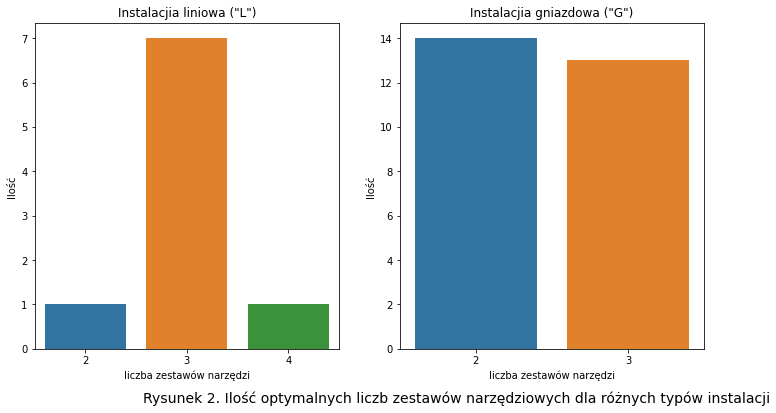

In [216]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
g3 = sns.barplot(x=pivot_df[pivot_df['Type'] == "L"]['m'].value_counts().index,
                 y=pivot_df[pivot_df['Type'] == "L"]['m'].value_counts().values,
                 ax=axs[0])
g3.set_title('Instalacjia liniowa ("L")')
g3.set(xlabel="liczba zestawów narzędzi", ylabel = "Ilość")

g4 = sns.barplot(x=pivot_df[pivot_df['Type'] == "G"]['m'].value_counts().index,
                 y=pivot_df[pivot_df['Type'] == "G"]['m'].value_counts().values,
                 ax=axs[1])
g4.set_title('Instalacjia gniazdowa ("G")')
g4.set(xlabel="liczba zestawów narzędzi", ylabel = "Ilość")

fig.text(0.25, 0, "Rysunek 2. Ilość optymalnych liczb zestawów narzędziowych dla różnych typów instalacji",
            fontsize=14); 

Używanie wszystkich czynników kosztów pokazuje, że bardzo mocno wpływa na łączne koszty i rozmieszczenie urządzeń na hali produkcyjnej dodatkowe koszty instalacji gniazdowej. Dla dalszej analizy stworzono model regresji liniowej na podstawie wyników symulacji.

In [217]:
results['Type'] = results['Type'].apply(lambda x: 0 if x == "L" else 1) #0 - liniowa, 1 - gniazdowa
results[['m', 'downtime_cost', 'kit_cost', 'additional_socket_cost']] = results[['m', 'downtime_cost', 'kit_cost', 'additional_socket_cost']].astype('int64')

In [218]:
y = results['Total_costs']
X = results.drop('Total_costs', axis=1)

In [220]:
clf = LinearRegression().fit(X, y)
print(np.round_(clf.intercept_, 3))
print(list(np.round_(clf.coef_, 3)))
print(clf.score(X, y))

-17972.919
[-0.579, 2000.165, 8234.565, 3.502, 1.0, 1.499]
0.9466760871542469


W ten sposób uzyskano wzór na przybliżone określenie kosztów całkowitych: $Total costs = -17972.919 - 0.579 \cdot Type + 2000.165 \cdot m + 8234.565 \cdot downtime cost + 3.502 \cdot kit cost + additional socket cost + 1.499 \cdot avg downtime$

# Analiza wrażliwości

Na podstawie badań można powiedzieć, że przy ceteris paribus zwiększenie kosztów o 0.5 zł za minutę bezczynności powoduje zwiększenie łącznych kosztów o ~5000 zł. Dodatkowe czynniki kosztów nie wpływają na wybór optymalnej ilości narzędzi dla układu liniowego.

# Wnioski i zalecenia

Według symulacji, optymalna liczba zestawów narzędzi dla układu liniowego nie zależy w dużym stopniu od kosztu jednostkowego przestoju oraz kosztu zestawu narzędzi. Dla układu liniowego zalecano używać 3 zestawa narzędzi. W wypadku układa gniazdowego liczba zestawów narzędzi zależy od czynników kosztów. Optymalnie może być używanie 2 lub 3 zestawów narzędzi. Dodatkowe koszty instalacji układa gniazdowego istotnie wpływają na wybór układu produkcyjnego. Jeżeli koszty nie są wielkie (< 1800 zł), to optymalnie będzie wybrać układ gniazdowy, we wszystkich innych wypadkach -  układ liniowy. Użycie dodatkowych źródeł kosztów nie wpływa na optymalną liczbę zestawów narzędzi, ale wpływa na wybór układu produkcyjnego.

Firmie GWINTEX S.A zalecano:

- zmniejszyć różnice w kosztach instalacji w ustawieniu gniazdowym ("G") w porównaniu do instalacji liniowej ("L") do 1800 zł. W takim wypadku optymalnym będzie wybór układu gniazdowego, liczba zestawów narzędzi - 2.
- jeżeli zmniejszyć różnice w kosztach instalacji w ustawieniu gniazdowym ("G") w porównaniu do instalacji liniowej ("L") do 1800 zł nie jest możliwie, to w takim wypadku zalecano użyć układ liniowy, liczba zestawów narzędzi - 3.